# Performance Evaluation

Evaluate OCT boundary estimation algorithms using the data set provided by [tia16].  As a first step towards evaluating our own algorithms, this script ensures we can reproduce the metrics/results of the original paper.

Note that we do *not* attempt any direct performance comparisons since the algorithms presented in the original paper did not have the benefit of training on this data set.  Instead, our goal is simply to assess general agreement.


### References
- [tia16] Tian et al. Performance evaluation of automated segmentation software on optical coherence tomography volume data. J. Biophotonics, 2016.

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys, time
from datetime import datetime

import numpy as np
import pylab as plt
from scipy.io import loadmat, savemat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions/Structures for OCT Data


In [65]:
def tian_load_data(mat_file):
    """ Loads (a subset of the) data set from [tia16]. 
    
    Each patient has 5 images: one from fovea, 2 from para, and 2 from peri.
    These images appear to be ordered consecutively by patient (i.e. the
    first five images are for the first patient, the next 5 the second, etc.)
    
    However, it is not immediately obvious that the fovea/peri/para follow
    the same order within each patient.  There are some follow-on data 
    structures (see later in this cell) to help with this.
    """
    mf = loadmat(mat_file)
    print(mf.keys())
    
    # for now we don't use all the 3rd-party estimates
    X = mf['volumedata']
    Y1 = mf['O1']
    Y2 = mf['O2']
    Y_IOWA = mf['IOWA']
    Y_AURA = mf['AURA']  # I assume this is Dufour's from table 4
        
    # shuffle dimensions 
    X = np.transpose(X, [2, 0, 1])
    Y1 = np.transpose(Y1, [2, 0, 1])
    Y2 = np.transpose(Y2, [2, 0, 1])
    Y_IOWA = np.transpose(Y_IOWA, [1, 2, 0])
    Y_AURA = np.transpose(Y_AURA, [1, 2, 0])
    
    # Note that the number of surface annotations in O1/O2 is 9.
    # Table 2 in [tia16] lists 11 possible surfaces, so here
    # we determine which subset of O1/O2 has the 5 surfaces used
    # in the study.
    print('\nGround Truth Availability:')
    print('-'*80)
    for b_id in range(mf['O1'].shape[0]):
        y1 = mf['O1'][b_id,...]
        y2 = mf['O2'][b_id,...]
        print('boundary %d, O1/O2 median value:   %0.03f / %0.03f' % (b_id, np.median(y1.flatten()), np.median(y2.flatten())))
    print('-'*80 + '\n')
    
    # based on analysis above
    boundaries_of_interest = np.array([0, 1, 2, 4, 7])
    Y1 = Y1[:, boundaries_of_interest, :]
    Y2 = Y2[:, boundaries_of_interest, :]
    
    print('OCT images have shape: ', X.shape)
    print('Truth has shape:       ', Y1.shape)
    
    return X, Y1, Y2, Y_IOWA, Y_AURA


# Here we map image indices to patient ids.
# This mapping seems to be implicit in the matlab data.
#
IMAGE_TO_PATIENT = { ii : np.floor(ii/5).astype(np.int32) for ii in range(50)}

# This data structure maps images to regions.
# These mappings do not appear to be stored in the matlab data structure, and were
# estimated by our domain experts.
# 
# Ref: Phil's email on august 17, 2017
#
FO = 'fovea'
PA = 'parafovea'
PE = 'perifovea'
IMAGE_TO_REGION = { 1 : FO,
                    2 : PA,
                    3 : PA,
                    4 : PE,
                    5 : PE,
                    6 : PE,
                    7 : PE,
                    8 : PA,
                    9 : PA,
                   10 : FO,
                   11 : PE, 
                   12 : PA, 
                   13 : FO,
                   14 : PA,
                   15 : PE, 
                   16 : PE,
                   17 : PA,
                   18 : FO,
                   19 : PA,
                   20 : PE,
                   21 : PE,
                   22 : PA,
                   23 : FO,
                   24 : PA,
                   25 : PE,
                   26 : PE,
                   27 : PA,
                   28 : FO,
                   29 : PA,
                   30 : PE,
                   31 : PA,
                   32 : FO,
                   33 : PA,
                   34 : PE,
                   35 : PE,
                   36 : PE,
                   37 : PA,
                   38 : FO,
                   39 : PA,
                   40 : PE,
                   41 : PA,
                   42 : FO,
                   43 : PA,
                   44 : PE,
                   45 : PE,
                   46 : PE,
                   47 : PA,
                   48 : FO,
                   49 : PA,
                   50 : PE}

# convert from numbering in email to 0-based idexing
IMAGE_TO_REGION = { x-1 : IMAGE_TO_REGION[x]  for x in IMAGE_TO_REGION.keys() }

print(IMAGE_TO_REGION)
print('')
print(IMAGE_TO_PATIENT)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Code and data for cropping images/truth
# (see email from N. Joshi on 8/31):
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def crop_columns(V, desired_width=644, axis=2):
    fovea_center_arr = np.asarray([382] * 5 + [370] * 5 + [394] * 5 + [370] * 5 + [376] * 5 + [372] * 5 + [372] * 5 + [442] * 5 + [390] * 5 + [366] * 5, dtype=int)
    a = (fovea_center_arr - np.floor(desired_width/2)).astype(np.int)
    b = (fovea_center_arr + np.ceil(desired_width/2)).astype(np.int)
    
    new_shape = list(V.shape)
    new_shape[axis] = desired_width
    V_out = np.zeros(new_shape, dtype=V.dtype)
    
    for ii in range(V.shape[0]):
        indices = np.arange(a[ii], b[ii])
        V_out[ii,...] = np.take(V[ii,...], indices, axis=axis-1)

    return V_out

{0: 'fovea', 1: 'parafovea', 2: 'parafovea', 3: 'perifovea', 4: 'perifovea', 5: 'perifovea', 6: 'perifovea', 7: 'parafovea', 8: 'parafovea', 9: 'fovea', 10: 'perifovea', 11: 'parafovea', 12: 'fovea', 13: 'parafovea', 14: 'perifovea', 15: 'perifovea', 16: 'parafovea', 17: 'fovea', 18: 'parafovea', 19: 'perifovea', 20: 'perifovea', 21: 'parafovea', 22: 'fovea', 23: 'parafovea', 24: 'perifovea', 25: 'perifovea', 26: 'parafovea', 27: 'fovea', 28: 'parafovea', 29: 'perifovea', 30: 'parafovea', 31: 'fovea', 32: 'parafovea', 33: 'perifovea', 34: 'perifovea', 35: 'perifovea', 36: 'parafovea', 37: 'fovea', 38: 'parafovea', 39: 'perifovea', 40: 'parafovea', 41: 'fovea', 42: 'parafovea', 43: 'perifovea', 44: 'perifovea', 45: 'perifovea', 46: 'parafovea', 47: 'fovea', 48: 'parafovea', 49: 'perifovea'}

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 4, 21: 4, 22: 4, 23: 4, 24: 4, 25: 5, 26: 5, 27: 5, 28: 5, 29: 

# Load Data

In [70]:
#
# Load the data, ground truth, and OCT estimates from [tia16]
#
# NOTE: in section 3.3 of [tia16] the authors specify:
#   "Smaller unsigned error indicates the training data is closer to our
#    testing ground truth created by the Observer 1"
# Therefore, we use Y_O1 as ground truth in the remainder.
#
tian_fn = '/Users/pekalmj1/Data/Tian_OCT/jbio201500239-sup-0003-Data-S1.mat'

X, Y_O1, Y_O2, Y_IOWA, Y_AURA = tian_load_data(tian_fn)

X = crop_columns(X)
Y_O1 = crop_columns(Y_O1)
Y_O2 = crop_columns(Y_O2)
Y_IOWA = crop_columns(Y_IOWA)
Y_AURA = crop_columns(Y_AURA)

print('X, Y shape post-crop:  ', X.shape, Y_O1.shape)

print('Y_AURA support:', np.sum(Y_AURA[0,0,:] > 0))

dict_keys(['__globals__', 'Spectralis', 'IOWA', 'volumedata', 'O1', 'Bern', '__version__', 'OCTRIMA', '__header__', 'AURA', 'O2'])

Ground Truth Availability:
--------------------------------------------------------------------------------
boundary 0, O1/O2 median value:   209.137 / 209.108
boundary 1, O1/O2 median value:   225.038 / 225.977
boundary 2, O1/O2 median value:   241.173 / 240.922
boundary 3, O1/O2 median value:   0.000 / 0.000
boundary 4, O1/O2 median value:   252.647 / 253.177
boundary 5, O1/O2 median value:   0.000 / 0.000
boundary 6, O1/O2 median value:   0.000 / 0.000
boundary 7, O1/O2 median value:   286.368 / 287.199
boundary 8, O1/O2 median value:   0.000 / 0.000
--------------------------------------------------------------------------------

OCT images have shape:  (50, 496, 768)
Truth has shape:        (50, 5, 768)
X, Y shape post-crop:   (50, 496, 644) (50, 5, 644)
Y_AURA support: 501


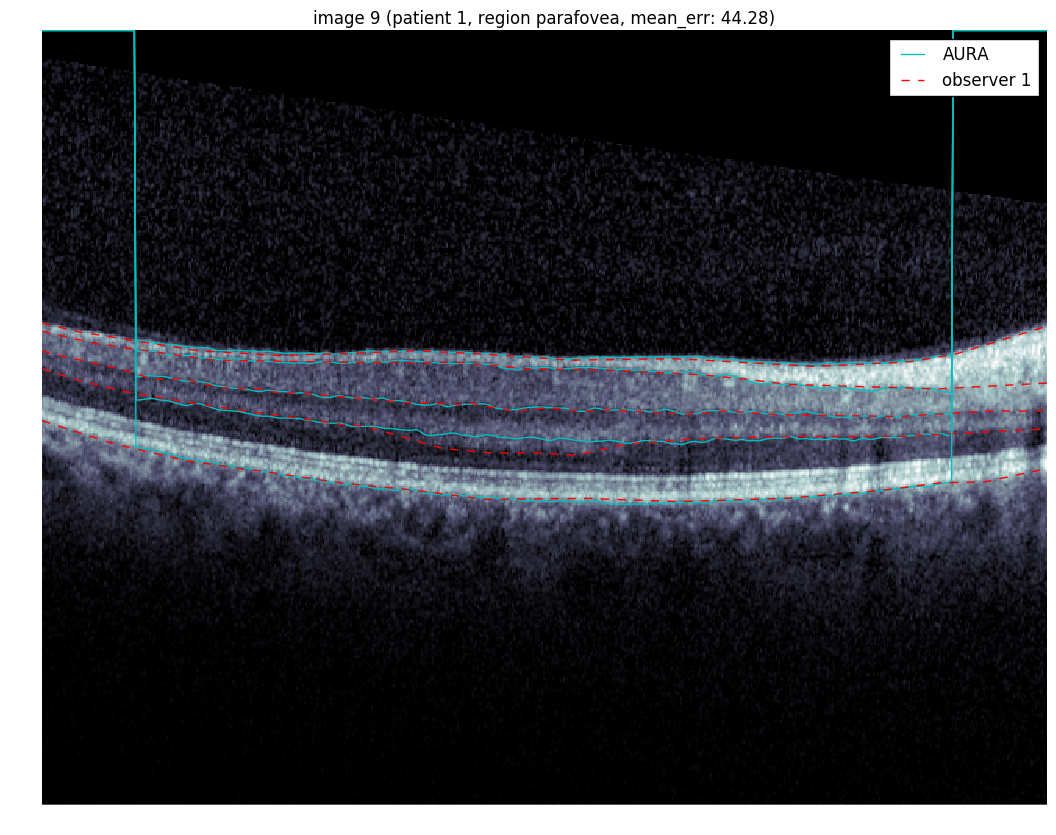

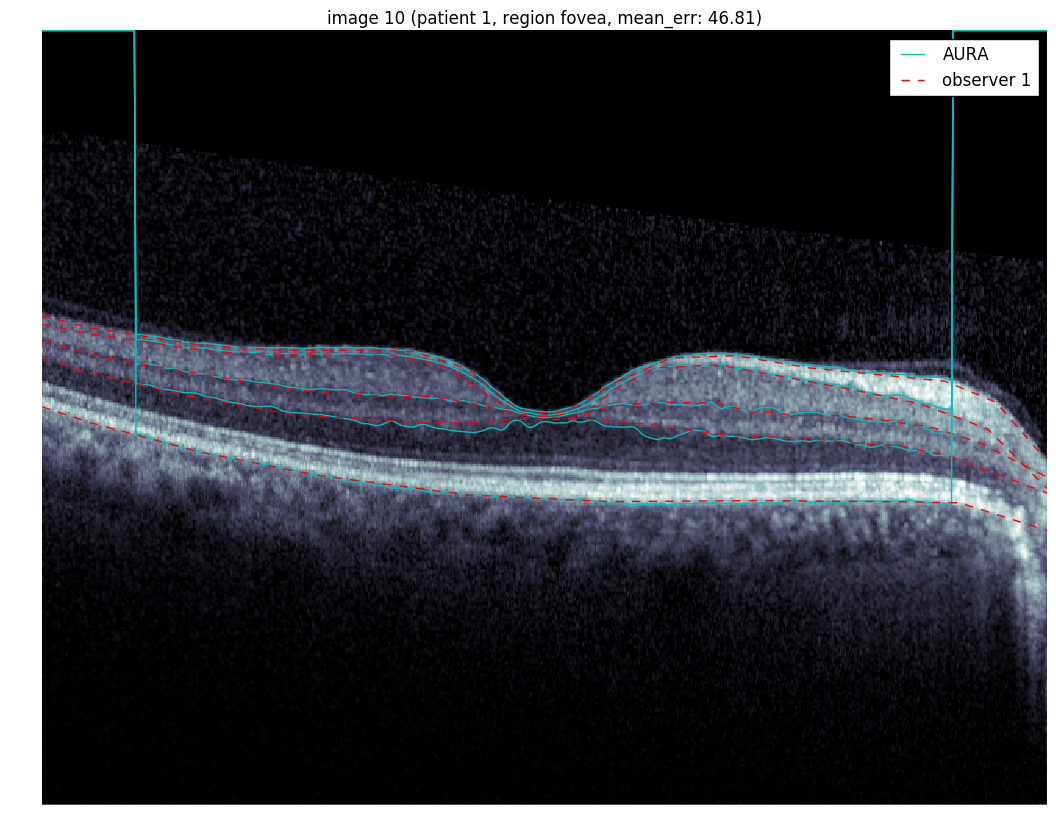

In [67]:
##
## Visually inspect a subset of the data
##

Y_ref = Y_AURA

for img_idx in [8, 9]:
    plt.figure(figsize=(20,10))
    plt.imshow(X[img_idx,...], interpolation='none', cmap='bone')
    
    err = Y_O1[img_idx, :, :] - Y_ref[img_idx, :, :]  # signed, per-pixel error
    mean_err = np.mean(np.abs(err))
    #mean_err = np.mean(np.sqrt(err**2)) 
    
    x_vals = np.arange(Y_O1.shape[-1])

    for boundary_id in range(Y_O1.shape[1]):
        plt.plot(x_vals, Y_ref[img_idx, boundary_id, :], '-c', label='AURA')
        plt.plot(x_vals, Y_O1[img_idx, boundary_id, :], '--r', label='observer 1')
        if boundary_id == 0: 
            plt.legend()

    plt.axis('off')
    plt.xlim([0, np.max(x_vals)])
    plt.ylim([0, X.shape[1]])
    plt.gca().invert_yaxis()
    
    plt.title('image %d (patient %d, region %s, mean_err: %0.2f)' % (img_idx+1, IMAGE_TO_PATIENT[img_idx], IMAGE_TO_REGION[img_idx], mean_err))
    

# Error Analysis

## Per-region errors
Here we reproduce a subset of table 5 from [tia16].  Our objective here is just to make sure we understand the error metrics and are processing the data properly.  Consequently, we do not attempt to reproduce the entire table.

In [64]:
def mean_unsigned_error_per_region(Y_true, Y_other):
    """Computes the per-surface error (in pixels) between the ground truth and some other set of estimates.
    As was done in table 5 of [tia16] we compute these errors on a per-surface basis.
    """
    n_images = Y_true.shape[0]
    n_surfaces = Y_true.shape[1]
    regions = [FO, PE, PA]
    
    mu_all = np.zeros((n_surfaces, len(regions)))
    sigma_all = np.zeros((n_surfaces, len(regions)))
    
   
    for r_idx, region in enumerate(regions):
        which_images = [x for x in range(n_images) if region == IMAGE_TO_REGION[x]]
        
        for s_idx in range(n_surfaces):
            err = np.abs(Y_true[which_images, s_idx, :] - Y_other[which_images, s_idx, :])
            mu_all[s_idx, r_idx] = np.mean(err)
            sigma_all[s_idx, r_idx] = np.std(err)
            
    # display a mini-"table" to stdout
    for s_idx in range(n_surfaces):
        for r_idx, region in enumerate(regions):
            print('surface %d, region %10s:  %0.2f' % (s_idx, region, mu_all[s_idx, r_idx]))
        print('')
            
    return mu_all, sigma_all
       

print('--------------------[ IOWA ]--------------------')
err_IOWA, _ = mean_unsigned_error_per_region(Y_O1, Y_IOWA)

print('--------------------[ AURA ]--------------------')
err_AURA, _ = mean_unsigned_error_per_region(Y_O1, Y_AURA)

--------------------[ IOWA ]--------------------
surface 0, region      fovea:  2.15
surface 0, region  perifovea:  2.01
surface 0, region  parafovea:  1.95

surface 1, region      fovea:  2.30
surface 1, region  perifovea:  1.58
surface 1, region  parafovea:  1.61

surface 2, region      fovea:  1.87
surface 2, region  perifovea:  2.02
surface 2, region  parafovea:  1.69

surface 3, region      fovea:  1.68
surface 3, region  perifovea:  1.55
surface 3, region  parafovea:  1.51

surface 4, region      fovea:  1.28
surface 4, region  perifovea:  1.35
surface 4, region  parafovea:  1.23

--------------------[ AURA ]--------------------
surface 0, region      fovea:  40.57
surface 0, region  perifovea:  37.72
surface 0, region  parafovea:  38.70

surface 1, region      fovea:  43.38
surface 1, region  perifovea:  41.38
surface 1, region  parafovea:  42.06

surface 2, region      fovea:  45.90
surface 2, region  perifovea:  43.34
surface 2, region  parafovea:  44.57

surface 3, region    

In [6]:
# under construction ; please ignore for now
        
def plot_l1_hist(errors, who):
    err_l1 = np.abs(errors)
    width=.8

    for b_id in range(err_l1.shape[1]):
        n_0_1 = np.sum(err_l1[:,b_id,:] < 1)
        n_1_2 = np.sum(err_l1[:,b_id,:] < 2) - n_0_1
        n_2_3 = np.sum(err_l1[:,b_id,:] < 3) - n_1_2 - n_0_1
        n_3_inf = np.sum(err_l1[:,b_id,:] >= 3)
        mu = np.mean(err_l1[:,b_id,:])
            
        n = err_l1[:,b_id,:].size
        n_0_1 /= n/100.
        n_1_2 /= n/100.
        n_2_3 /= n/100.
        n_3_inf /= n/100.

        plt.bar(b_id, n_0_1, width, color='#3368ff')
        plt.bar(b_id, n_1_2, width, bottom=n_0_1, color='#ffa833')
        plt.bar(b_id, n_2_3, width, bottom=n_0_1+n_1_2, color='#aaaaaa')
        plt.bar(b_id, n_3_inf, width, bottom=n_0_1+n_1_2+n_2_3, color='#fff633')
        plt.gca().annotate('%0.3f' % mu, xy=(b_id,103))
    
    mu = np.mean(err_l1)
    plt.xlabel('boundary')
    plt.ylim([0,110])
    plt.title('%s (%0.3f)' % (who, mu))
        